# Import all kind of stuff

In [87]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt

import sys
import importlib

import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/Users/oliver/Documents/p5control-bluefors-evaluation")

from utilities.corporate_design_colors_v4 import cmap, colors

from theory.models.dynes_np import density_of_states
from theory.models.dynes_np import fermi_distribution
from theory.models.dynes_np import get_current_dynes
from theory.models.models import get_I_nA

from theory.models.constants import k_B_meV, G_0_muS

# Set plot fontsizes

In [88]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams["axes.labelsize"] = 8
plt.rcParams["font.size"] = 9
plt.rcParams["legend.fontsize"] = 8
plt.rcParams["xtick.labelsize"] = 8
plt.rcParams["ytick.labelsize"] = 8

In [89]:
textwidth = 4.25279  # in

print(
    " 1.0*textwidth",
    textwidth,
    "\n",
    "0.9*textwidth",
    0.9 * textwidth,
    "\n",
    "0.8*textwidth",
    0.8 * textwidth,
    "\n",
    "0.7*textwidth",
    0.7 * textwidth,
    "\n",
    "0.6*textwidth",
    0.7 * textwidth,
    "\n",
    "0.5*textwidth",
    0.5 * textwidth,
    "\n",
    "0.4*textwidth",
    0.4 * textwidth,
    "\n",
)

 1.0*textwidth 4.25279 
 0.9*textwidth 3.8275110000000003 
 0.8*textwidth 3.402232 
 0.7*textwidth 2.976953 
 0.6*textwidth 2.976953 
 0.5*textwidth 2.126395 
 0.4*textwidth 1.701116 



# gap-suppression

In [90]:
def Delta_of_T(T: NDArray[np.float64], T_C: float = 1.0, Delta_0: float = 1.0):
    Delta = np.where(T != 0, Delta_0 * np.tanh(1.74 * np.sqrt(T_C / T - 1)), 1.0)
    return Delta


T = np.linspace(0, 1, 101)

Delta = Delta_of_T(T)

/var/folders/kc/8fnzl3f94vxgl8w4wm3wfvk80000gn/T/ipykernel_1203/816220097.py:2: RuntimeWarning: divide by zero encountered in divide
  Delta = np.where(T != 0, Delta_0 * np.tanh(1.74 * np.sqrt(T_C / T - 1)), 1.0)


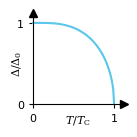

In [91]:
fig, ax = plt.subplots(figsize=(1.2, 1.2))

# Plot the simplified gap curve
ax.plot(T, Delta, color=colors(0), lw=1.5)
color = "k"  # colors(2)

# Remove frame
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)


# Keep only left and bottom spines, make them arrows
ax.spines["left"].set_position(("data", 0))
ax.spines["bottom"].set_position(("data", 0))
ax.spines["left"].set_bounds(0, 1.1)
ax.spines["bottom"].set_bounds(0, 1.1)

ax.spines["bottom"].set_color(color)
ax.spines["left"].set_color(color)

# Draw arrow heads
ax.plot(
    1.12, 0.085, ">", color=color, transform=ax.get_xaxis_transform(), clip_on=False
)
ax.plot(
    0.085, 1.12, "^", color=color, transform=ax.get_yaxis_transform(), clip_on=False
)

# Simplify ticks
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.tick_params(
    axis="both",
    direction="out",
    length=3,
    labelsize=8,
    color=color,
    labelcolor=color,
)

# Move axis labels near arrow tips
ax.text(0.4, -0.2, "$T/T_\\mathrm{C}$", ha="left", va="center", fontsize=8)
ax.text(
    -0.2,
    0.35,
    "$\\Delta/\\Delta_0$",
    ha="center",
    va="bottom",
    rotation=90,
    fontsize=8,
)

# Limits with little margins for arrows
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)

ax.set_aspect("equal")
fig.tight_layout(pad=0.1)
fig.savefig("gap-suppression.pgf")
fig.savefig("gap-suppression.pdf")

# dos-fermi

In [119]:
Delta_meV = 0.180
E_meV = np.linspace(-2.5 * Delta_meV, 2.5 * Delta_meV, 1001)
Gammas_Delta = np.array([0, 1, 2.5, 5]) * 1e-2
Ts_TC = np.array([0, 0.2, 0.5, 0.8, 1])
T_C = Delta_meV / (1.764 * k_B_meV)

Ns = np.full((Gammas_Delta.shape[0], E_meV.shape[0]), np.nan)
for i, Gamma in enumerate(Gammas_Delta):
    Ns[i, :] = density_of_states(
        E_eV=E_meV * 1e-3,
        Delta_eV=Delta_meV * 1e-3,
        Gamma_eV=Gamma * Delta_meV * 1e-3,
    )

fs = np.full((Ts_TC.shape[0], E_meV.shape[0]), np.nan)
for i, T in enumerate(Ts_TC):
    fs[i, :] = fermi_distribution(E_eV=E_meV * 1e-3, T_K=T * T_C)

Ts_temp, Gammas_temp = np.meshgrid(Ts_TC, Gammas_Delta)
Gamma_map = cmap(clim=[0.1, 0.8], inverse=True)
T_map = cmap(clim=[0.1, 0.8], inverse=True)

/Users/oliver/Documents/p5control-bluefors-evaluation/theory/models/dynes_np.py:116: RuntimeWarning: divide by zero encountered in divide
  N_E = np.divide(E_complex, denom)
/Users/oliver/Documents/p5control-bluefors-evaluation/theory/models/dynes_np.py:116: RuntimeWarning: invalid value encountered in divide
  N_E = np.divide(E_complex, denom)


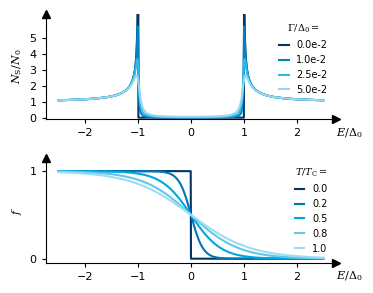

In [125]:
fig, [ax_dos, ax_fd] = plt.subplots(
    2,
    1,
    figsize=(3.8, 3),
)

for i, Gamma in enumerate(Gammas_Delta):
    ax_dos.plot(
        E_meV / Delta_meV,
        Ns[i, :],
        color=cmap(clim=(0.1, 0.8))(i / len(Gammas_Delta)),
        zorder=i,
        label=f"{Gamma*1e2}e-2",
    )
for i, T in enumerate(Ts_TC):
    ax_fd.plot(
        E_meV / Delta_meV,
        fs[i, :],
        color=cmap(clim=(0.1, 0.8))(i / len(Ts_TC)),
        zorder=i,
        label=f"{T:1.1f}",
    )

ax_dos.set_ylim(-0.1, 6.5)
ax_fd.set_ylim(-0.05, 1.15)

for ax in [ax_dos, ax_fd]:

    # Remove frame
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()

    ax_trans = ax.get_xaxis_transform()
    # Draw arrow heads
    ax.plot(x_lim[1], y_lim[0], ">", color="k", clip_on=False)
    ax.plot(x_lim[0], y_lim[1], "^", color="k", clip_on=False)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    # Simplify ticks
    # ax.set_xticks([-3, -2, -1, 0, 1, 2, 3])
    # ax.set_yticks([0, 1])
    ax.tick_params(
        axis="both",
        direction="out",
        length=3,
        labelsize=8,
        color=color,
        labelcolor=color,
    )
ax_dos.text(x_lim[1], -1, "$E/\\Delta_0$", ha="left", va="center", fontsize=8)
ax_fd.text(x_lim[1], -0.2, "$E/\\Delta_0$", ha="left", va="center", fontsize=8)

ax_dos.set_ylabel("$N_\\mathrm{S}/N_0$")
ax_fd.set_ylabel("$f$")

ax_dos.legend(
    title="$\\Gamma/\\Delta_0 = $",
    handlelength=1.0,
    loc="upper right",
    frameon=False,
    fontsize=7,
    title_fontsize=7,
)
ax_fd.legend(
    title=r"$T/T_\mathrm{C} = $",
    handlelength=1.0,
    loc="upper right",
    frameon=False,
    fontsize=7,
    title_fontsize=7,
)

ax_dos.set_yticks([0, 1, 2, 3, 4, 5])
ax_fd.set_yticks([0, 1])

fig.tight_layout()
fig.savefig("dos-fermi.pgf")
fig.savefig("dos-fermi.pdf")

0.0 1.31570500244332 0.0002
0.4 1.31570500244332 0.00019444133336630397
0.5 1.31570500244332 0.00018804532807854552
0.8 1.31570500244332 0.00014027482618766247
0.9 1.31570500244332 0.0001045330859371641
0.95 1.31570500244332 7.585000223505532e-05


/var/folders/kc/8fnzl3f94vxgl8w4wm3wfvk80000gn/T/ipykernel_1203/816220097.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  Delta = np.where(T != 0, Delta_0 * np.tanh(1.74 * np.sqrt(T_C / T - 1)), 1.0)


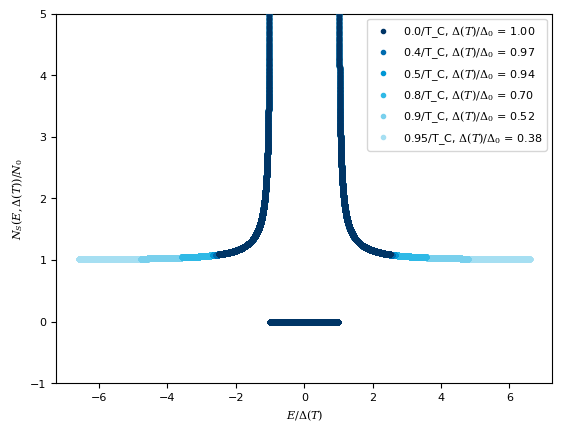

In [113]:
# DOS does not smear with T!
Delta = 0.2
E = np.linspace(-2.5 * Delta, 2.5 * Delta, 25001)
Ts = np.array([0, 0.4, 0.5, 0.8, 0.9, 0.95])

Ns = np.full((Ts.shape[0], E.shape[0]), np.nan)
for i, T in enumerate(Ts):
    T_C = Delta / 1.764 / k_B_meV
    Delta_T = Delta_of_T(
        T=T * Delta / 1.764 / k_B_meV, T_C=Delta / 1.764 / k_B_meV, Delta_0=Delta * 1e-3
    )
    if Delta_T == 1.0:
        Delta_T = Delta * 1e-3
    print(T, T_C, Delta_T)
    Ns[i, :] = density_of_states(E * 1e-3, Delta_eV=Delta_T, Gamma_eV=0)
    plt.plot(
        E * 1e-3 / Delta_T,
        Ns[i, :],
        ".",
        color=cmap(clim=(0.1, 0.8))(i / len(Ts)),
        zorder=len(Ts) - i,
        label=f"{T}/T_C, $\\Delta(T)/\\Delta_0$ = {Delta_T/Delta*1e3:.2f}",
    )

plt.xlabel("$E/\\Delta(T)$")
plt.ylabel("$N_S(E, \\Delta(T))/N_0$")
plt.ylim(-1, 5)
plt.legend()

# tunnel-current

Attention: don't use $G_0$ yet. its not introduced. stick to $G_N$

Dynes: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Text(0, 0.5, 'd$I/$d$V$ ($G_0$)')

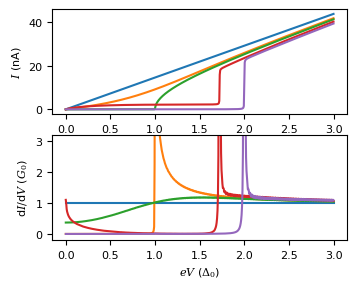

In [114]:
# Test
Delta_meV = 0.189
V_mV = np.linspace(0, 3 * Delta_meV, 601)  # mV
tau = 1
G_N = tau * G_0_muS
T_K = 0.8
Gamma_meV = 0.0

I_NN = G_N * V_mV  # nA
dIdV_NN = np.gradient(I_NN, V_mV) / G_0_muS

I_NS0 = get_I_nA(
    V_mV=V_mV,
    tau=tau,
    Delta_meV=np.array([0, Delta_meV]),
    T_K=0.001,
    Gamma_meV=Gamma_meV,
    model="dynes",
)
dIdV_NS0 = np.gradient(I_NS0, V_mV) / G_0_muS

I_NS = get_I_nA(
    V_mV=V_mV,
    tau=tau,
    Delta_meV=np.array([0, Delta_meV]),
    T_K=T_K,
    Gamma_meV=Gamma_meV,
    model="dynes",
)
dIdV_NS = np.gradient(I_NS, V_mV) / G_0_muS

I_SS0 = get_I_nA(
    V_mV=V_mV,
    tau=tau,
    Delta_meV=np.array([Delta_meV, Delta_meV]),
    T_K=0.001,
    Gamma_meV=Gamma_meV,
    model="dynes",
)
dIdV_SS0 = np.gradient(I_SS0, V_mV) / G_0_muS

I_SS = get_I_nA(
    V_mV=V_mV,
    tau=tau,
    Delta_meV=np.array([Delta_meV, Delta_meV]),
    T_K=T_K,
    Gamma_meV=Gamma_meV,
    model="dynes",
)
dIdV_SS = np.gradient(I_SS, V_mV) / G_0_muS

fig, [ax_IV, ax_dIdV] = plt.subplots(
    2,
    1,
    figsize=(3.8, 3),
)

ax_IV.plot(V_mV / Delta_meV, I_NN)
ax_IV.plot(V_mV / Delta_meV, I_NS)
ax_IV.plot(V_mV / Delta_meV, I_NS0)
ax_IV.plot(V_mV / Delta_meV, I_SS)
ax_IV.plot(V_mV / Delta_meV, I_SS0)
ax_dIdV.plot(V_mV / Delta_meV, dIdV_NN)
ax_dIdV.plot(V_mV / Delta_meV, dIdV_NS0)
ax_dIdV.plot(V_mV / Delta_meV, dIdV_NS)
ax_dIdV.plot(V_mV / Delta_meV, dIdV_SS)
ax_dIdV.plot(V_mV / Delta_meV, dIdV_SS0)

ax_dIdV.set_ylim(-0.2, 3.2)

ax_IV.set_xlabel("$eV$ ($\\Delta_0$)")
ax_dIdV.set_xlabel("$eV$ ($\\Delta_0$)")
ax_IV.set_ylabel("$I$ (nA)")
ax_dIdV.set_ylabel("d$I/$d$V$ ($G_0$)")

In [67]:
# generate data
Delta_meV = 0.189
V_mV = np.linspace(0, 3 * Delta_meV, 601)  # mV
tau = 1
T_TC = np.array([0, 0.2, 0.4, 0.6, 0.8])
T_C_K = 1.2
Gamma_Delta = np.array([0, 1, 2.5, 5.0]) * 1e-2

I_NN = tau * G_0_muS * V_mV  # nA
dIdV_NN = np.gradient(I_NN, V_mV) / G_0_muS

I_NS_T = np.full((T_TC.shape[0], V_mV.shape[0]), np.nan)
I_SS_T = np.full((T_TC.shape[0], V_mV.shape[0]), np.nan)
I_NS_Gamma = np.full((Gamma_Delta.shape[0], V_mV.shape[0]), np.nan)
I_SS_Gamma = np.full((Gamma_Delta.shape[0], V_mV.shape[0]), np.nan)

for i, T in enumerate(T_TC):
    I_NS_T[i, :] = get_I_nA(
        V_mV=V_mV,
        tau=tau,
        Delta_meV=np.array([0, Delta_meV]),
        T_K=T * T_C_K,
        Gamma_meV=0.0,
        model="dynes",
    )
    I_SS_T[i, :] = get_I_nA(
        V_mV=V_mV,
        tau=tau,
        Delta_meV=np.array([Delta_meV, Delta_meV]),
        T_K=T * T_C_K,
        Gamma_meV=0.0,
        model="dynes",
    )

for i, Gamma in enumerate(Gamma_Delta):
    I_NS_Gamma[i, :] = get_I_nA(
        V_mV=V_mV,
        tau=tau,
        Delta_meV=np.array([0, Delta_meV]),
        T_K=0.0,
        Gamma_meV=Gamma * Delta_meV,
        model="dynes",
    )
    I_SS_Gamma[i, :] = get_I_nA(
        V_mV=V_mV,
        tau=tau,
        Delta_meV=np.array([Delta_meV, Delta_meV]),
        T_K=0.0,
        Gamma_meV=Gamma * Delta_meV,
        model="dynes",
    )

dIdV_NS_T = np.gradient(I_NS_T, V_mV, axis=1) / G_0_muS
dIdV_SS_T = np.gradient(I_SS_T, V_mV, axis=1) / G_0_muS
dIdV_NS_Gamma = np.gradient(I_NS_Gamma, V_mV, axis=1) / G_0_muS
dIdV_SS_Gamma = np.gradient(I_SS_Gamma, V_mV, axis=1) / G_0_muS

Dynes: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


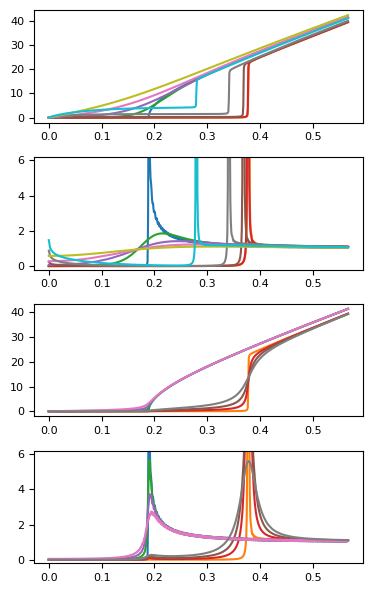

In [126]:
fig, [ax_IV_T, ax_dIdV_T, ax_IV_Gamma, ax_dIdV_Gamma] = plt.subplots(
    4,
    1,
    figsize=(3.8, 6),
)

for i, T in enumerate(T_TC):
    ax_IV_T.plot(V_mV, I_NS_T[i, :])
    ax_IV_T.plot(V_mV, I_SS_T[i, :])
    ax_dIdV_T.plot(V_mV, dIdV_NS_T[i, :])
    ax_dIdV_T.plot(V_mV, dIdV_SS_T[i, :])


for i, Gamma in enumerate(Gamma_Delta):
    ax_IV_Gamma.plot(V_mV, I_NS_Gamma[i, :])
    ax_IV_Gamma.plot(V_mV, I_SS_Gamma[i, :])
    ax_dIdV_Gamma.plot(V_mV, dIdV_NS_Gamma[i, :])
    ax_dIdV_Gamma.plot(V_mV, dIdV_SS_Gamma[i, :])

ax_dIdV_T.set_ylim(-0.2, 6.2)
ax_dIdV_Gamma.set_ylim(-0.2, 6.2)

ax_IV.set_xlabel("$eV$ ($\\Delta_0$)")
ax_dIdV.set_xlabel("$eV$ ($\\Delta_0$)")
ax_IV.set_ylabel("$I$ (nA)")
ax_dIdV.set_ylabel("d$I/$d$V$ ($G_0$)")
fig.tight_layout()
fig.savefig("tunnel-current.pgf")
fig.savefig("tunnel-current.pdf")

In [127]:

    I_NS_T[i, :] = get_I_nA(
        V_mV=V_mV,
        tau=tau,
        Delta_meV=np.array([0, Delta_meV]),
        T_K=T * T_C_K,
        Gamma_meV=0.0,
        nu_GHz = 10.0,
        A_mV = 1.0,
        model="dynes+pat",
    )

TypeError: get_I_nA() got an unexpected keyword argument 'nu_GHz'